In [1]:
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import seaborn as sns

## Read data

In [2]:
v = '07'
file_name = f"../File/FrontendFileGroup/storm-frontend-202003{v}-mask-group.txt"
# file_name = f"../File/FrontendFileGroup/storm-frontend-202003{v}-group.txt"

logs = pd.read_csv(file_name, index_col= 0, nrows = 1e4)

In [3]:
print("Total number of logs:", logs.shape[0])

Total number of logs: 10000


## Extract information
Once we read the data, we can focus on the variable message and try to extract meaningful information from it.

### Clearing and tokenizing messages

In [4]:
# Reduce to lowercase and split in tokens
tokens_per_message = [x.lower().split() for x in logs.message]

In [5]:
tokens_per_message[:2]

[['process_request',
  ':',
  'connection',
  'from<ip>:d9',
  'result',
  'for',
  'request',
  "'ls'",
  'is',
  "'srm_success'",
  'ns1__srmls',
  ':',
  'request:',
  'ls.',
  'ip:<ip>:d9.',
  'client',
  'dn:',
  '/dc=ch/dc=cern/ou=organic',
  'units/ou=users/cn=ddmadmin/cn=531497/cn=robot:',
  'atlas',
  'data',
  'management'],
 ["['p',",
  "'r',",
  "'o',",
  "'c',",
  "'e',",
  "'s',",
  "'s',",
  "'_',",
  "'r',",
  "'e',",
  "'q',",
  "'u',",
  "'e',",
  "'s',",
  "'t',",
  "'",
  "',",
  "':',",
  "'",
  "',",
  "'c',",
  "'o',",
  "'n',",
  "'n',",
  "'e',",
  "'c',",
  "'t',",
  "'i',",
  "'o',",
  "'n',",
  "'",
  "',",
  "'f',",
  "'r',",
  "'o',",
  "'m',",
  "'",
  "',",
  "'<',",
  "'i',",
  "'p',",
  "'>']"]]

In [6]:
# Retrieve the set of all tokens used in the error messages
word_set = set()
for mess in tokens_per_message:
    word_set = word_set.union(set(mess))
    
word_set

{'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatatape/data17_13tev/raw/other/data17_13tev.00340368.physics_main.daq.raw/data17_13tev.00340368.physics_main.daq.raw._lb0652._sfo-6._0001.data',
 "'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatatape/data17_13tev/raw/other/data17_13tev.00340368.physics_main.daq.raw/data17_13tev.00340368.physics_main.daq.raw._lb0202._sfo-8._0001.data_1517872211'",
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13tev/aa/bd/data17_13tev.00340030.physics_main.daq.raw._lb0175._sfo-5._0001.data.',
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13tev/fb/d6/draw_rpvll.20624657._002784.pool.root.1.rucio.upload',
 '<ip>.154.208.8.',
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data18_13tev/55/34/daod_exot4.20023374._000054.pool.root.1.',
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data16_13tev/03/e4/daod_stdm5.20711631._000003.pool.root.1.rucio.upload.',
 "'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdata

In [7]:
print("We have {} logs messages, for a total of {} unique tokens adopted.".format(
    len(tokens_per_message), len(word_set)))

We have 10000 logs messages, for a total of 10113 unique tokens adopted.


In [8]:
# Setup a dictionary with frequency of all tokens per each message (initialized to 0)
word_dict = [dict.fromkeys(word_set, 0) for i in range(len(tokens_per_message))]
print("Number of tokens:", len(word_dict[0]))

word_dict[0]

Number of tokens: 10113


{'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatatape/data17_13tev/raw/other/data17_13tev.00340368.physics_main.daq.raw/data17_13tev.00340368.physics_main.daq.raw._lb0652._sfo-6._0001.data': 0,
 "'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatatape/data17_13tev/raw/other/data17_13tev.00340368.physics_main.daq.raw/data17_13tev.00340368.physics_main.daq.raw._lb0202._sfo-8._0001.data_1517872211'": 0,
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13tev/aa/bd/data17_13tev.00340030.physics_main.daq.raw._lb0175._sfo-5._0001.data.': 0,
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13tev/fb/d6/draw_rpvll.20624657._002784.pool.root.1.rucio.upload': 0,
 '<ip>.154.208.8.': 0,
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data18_13tev/55/34/daod_exot4.20023374._000054.pool.root.1.': 0,
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data16_13tev/03/e4/daod_stdm5.20711631._000003.pool.root.1.rucio.upload.': 0,
 "'srm://storm-fe.cr.cnaf.in

In [9]:
# Compute raw frequencies of each token per each message
for i in range(len(logs.message)):
    for word in tokens_per_message[i]:
        word_dict[i][word] += 1
        
word_dict[0]

{'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatatape/data17_13tev/raw/other/data17_13tev.00340368.physics_main.daq.raw/data17_13tev.00340368.physics_main.daq.raw._lb0652._sfo-6._0001.data': 0,
 "'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatatape/data17_13tev/raw/other/data17_13tev.00340368.physics_main.daq.raw/data17_13tev.00340368.physics_main.daq.raw._lb0202._sfo-8._0001.data_1517872211'": 0,
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13tev/aa/bd/data17_13tev.00340030.physics_main.daq.raw._lb0175._sfo-5._0001.data.': 0,
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13tev/fb/d6/draw_rpvll.20624657._002784.pool.root.1.rucio.upload': 0,
 '<ip>.154.208.8.': 0,
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data18_13tev/55/34/daod_exot4.20023374._000054.pool.root.1.': 0,
 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data16_13tev/03/e4/daod_stdm5.20711631._000003.pool.root.1.rucio.upload.': 0,
 "'srm://storm-fe.cr.cnaf.in

In [10]:
print("Dictionary dimensions:\n", pd.DataFrame(word_dict).shape)

# Visualization
# pd.DataFrame(word_dict)

Dictionary dimensions:
 (10000, 10113)


### Compute TF-IDF scores

Once we have messages divided in words and we have computed the raw frequencies of each token in each sentence, then we can proceed and compute the **tf-idf** score for each message.

In [11]:
c = 0
for i, dic in enumerate(tokens_per_message):
    if not len(dic):
        print(i, errors.loc[i])
        c += 1

In [12]:
print("Warning: there are {} blanck messages which will be excluded from the analysis.".format(c))

Frequenza delle parole in uno stesso processo

In [13]:
def compute_tf(word_dict, l): # l is the message from logs
    tf = {}
    sum_nk = len(l)
    for word, count in word_dict.items():
        try:
            tf[word] = count/sum_nk
        except ZeroDivisionError:
            tf[word] = 0
    return tf

tf = [compute_tf(word_dict[i], tokens_per_message[i])
      for i in range(len(tokens_per_message))] #if sum(word_dict[i].values())]
# tf_A = compute_tf(word_dict_A, l_A)
# tf_B = compute_tf(word_dict_B, l_B)
# tf_C = compute_tf(word_dict_C, l_C)

Frequenza con cui una parola compare nei processi

In [14]:
def compute_idf(strings_list):
    n = len(strings_list)
    idf = dict.fromkeys(strings_list[0].keys(), 0)
    for l in strings_list:
        for word, count in l.items():
            if count > 0:
                idf[word] += 1

    for word, v in idf.items():
        idf[word] = np.log(n / float(v))
    return idf

idf = compute_idf(word_dict)
# idf = compute_idf([word_dict_A, word_dict_B, word_dict_C])

In [15]:
len(word_dict), len(tf), len(tf[0]), len(idf)

(10000, 10000, 10113, 10113)

In [16]:
def compute_tf_idf(tf, idf):
    tf_idf = dict.fromkeys(tf.keys(), 0)
    for word, v in tf.items():
        tf_idf[word] = v * idf[word]
    return tf_idf
    
tf_idf =  [compute_tf_idf(tf[i], idf) for i in range(len(tf))]
# tf_idf_A = compute_tf_idf(tf_A, idf)
# tf_idf_B = compute_tf_idf(tf_B, idf)
# tf_idf_C = compute_tf_idf(tf_C, idf)

In [17]:
# Visualization
# pd.DataFrame(tf_idf)

### Alternative using Scikit-Learn: TfidfVectorizer

In [18]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd


print("Extracting features from the training dataset using a sparse vectorizer")
# t0 = time()
vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.02, stop_words='english',
                             use_idf=True)
# vectorizer = TfidfVectorizer(stop_words='english',
#                              use_idf=True)
X = vectorizer.fit_transform(logs.message)

Extracting features from the training dataset using a sparse vectorizer
CPU times: total: 1.61 s
Wall time: 2.07 s


In [19]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': None,
 'min_df': 0.02,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

# Clustering

As a first attempt we can try a simple clustering algorithm such as *K-means*. 

<div class="alert alert-block alert-info">
<b>Note:</b> We repeat the information extraction step through the scikit-learn routine TfidfVectorizer just for convenience (so to avoid problems with variable types and to apply easily the clustering algorithm).
</div>

In [20]:
# import libraries
from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

# Extract TF-IDF information
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.02, stop_words='english',
                             use_idf=True)
# vectorizer = TfidfVectorizer(stop_words='english',
#                              use_idf=True)
X = vectorizer.fit_transform(logs.message)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()


# Apply LSA for dimensionality reduction to get a lower-dimensional embedding space
print("Performing dimensionality reduction using LSA")
t0 = time()

# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(25)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

Extracting features from the training dataset using a sparse vectorizer
done in 0.986216s
n_samples: 10000, n_features: 93

Performing dimensionality reduction using LSA
done in 0.181462s
Explained variance of the SVD step: 96%



Once we have a somewhat convenient subspace for representing the words/tokens, and hence the messages, then we cann proceed and apply the clustering algorithm.

<div class="alert alert-block alert-info">
    <b>Note:</b> In the following, we pretend the variable <i>category</i> as a true label for the clustering results. This is just to show how one could evaluate results of the unsupervised model when target labels are available.
</div>

In [21]:
%%time

# set number of clusters (hyperparameter)
n_clusters = 12

# run K-Means algorithm: 6 clusters
km = KMeans(n_clusters=n_clusters, 
            init='k-means++', 
            max_iter=500, 
            n_init=100,
            verbose=1)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(max_iter=500, n_clusters=12, n_init=100, verbose=1)
Initialization complete
Iteration 0, inertia 2514.492509669532
Iteration 1, inertia 1602.796988600709
Iteration 2, inertia 1543.2742299046342
Iteration 3, inertia 1536.819428522657
Iteration 4, inertia 1523.118752746785
Iteration 5, inertia 1516.5101863616303
Iteration 6, inertia 1510.1422968131612
Iteration 7, inertia 1502.3757950173258
Iteration 8, inertia 1493.4017949548918
Iteration 9, inertia 1485.8371385777702
Iteration 10, inertia 1485.699967054932
Iteration 11, inertia 1485.6905778095097
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 1869.2578333581705
Iteration 1, inertia 1510.5524951153375
Iteration 2, inertia 1466.3943275523302
Iteration 3, inertia 1420.1101672653651
Iteration 4, inertia 1388.6160273453052
Iteration 5, inertia 1382.275756542289
Iteration 6, inertia 1365.2415715246627
Iteration 7, inertia 1363.5169503226628
Iteration 8, inertia 1

Iteration 1, inertia 1459.4167011304526
Iteration 2, inertia 1436.7327437789056
Iteration 3, inertia 1436.5492996627786
Iteration 4, inertia 1436.5408959153744
Iteration 5, inertia 1436.5374633981264
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 1956.1662619248068
Iteration 1, inertia 1533.9214512802007
Iteration 2, inertia 1510.2402148191306
Iteration 3, inertia 1492.016627226447
Iteration 4, inertia 1481.7820091123347
Iteration 5, inertia 1481.0197973107563
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 2026.4622986283243
Iteration 1, inertia 1466.3733949413636
Iteration 2, inertia 1437.533696684397
Iteration 3, inertia 1416.421803379509
Iteration 4, inertia 1392.9254295062854
Iteration 5, inertia 1391.1909556637092
Iteration 6, inertia 1391.17902724007
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 2172.2782035357586
Iteration 1, inertia 1495.207439450

Iteration 0, inertia 2016.4077206183924
Iteration 1, inertia 1419.0047457682517
Iteration 2, inertia 1391.7514566405728
Iteration 3, inertia 1387.952610306706
Iteration 4, inertia 1387.7588531775464
Iteration 5, inertia 1387.729876254984
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 1875.7353757618107
Iteration 1, inertia 1462.2015243341305
Iteration 2, inertia 1429.3405805658417
Iteration 3, inertia 1400.13048780495
Iteration 4, inertia 1381.8222624573114
Iteration 5, inertia 1381.2715574797412
Iteration 6, inertia 1377.6188325955186
Iteration 7, inertia 1360.6406939314697
Iteration 8, inertia 1359.0963570818035
Iteration 9, inertia 1355.845266083473
Iteration 10, inertia 1355.7993643738766
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 2012.2723845623025
Iteration 1, inertia 1482.6359822800284
Iteration 2, inertia 1453.874545105315
Iteration 3, inertia 1430.5417285458393
Iteration 4, inertia 142

Iteration 1, inertia 1463.621505640533
Iteration 2, inertia 1416.0801648891575
Iteration 3, inertia 1380.1927911351427
Iteration 4, inertia 1377.6155671863817
Iteration 5, inertia 1377.5500628763828
Iteration 6, inertia 1377.2459722852896
Iteration 7, inertia 1376.9726031108964
Iteration 8, inertia 1376.9394832097726
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 2164.686725433065
Iteration 1, inertia 1492.2429523955084
Iteration 2, inertia 1438.8953371565422
Iteration 3, inertia 1417.479531014492
Iteration 4, inertia 1415.7692057395398
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 2050.362632538316
Iteration 1, inertia 1529.8243445849262
Iteration 2, inertia 1515.3687630931408
Iteration 3, inertia 1512.5068139322038
Iteration 4, inertia 1510.581417712906
Iteration 5, inertia 1509.7642998006072
Iteration 6, inertia 1509.6623068983097
Iteration 7, inertia 1509.6421873048262
Converged at iteration 7:

class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')

Parameters:

- n_clusters: int, default=8
    - The number of clusters to form as well as the number of centroids to generate.

- n_init: int, default=10
    - Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

- max_iter: int, default=300
    - Maximum number of iterations of the k-means algorithm for a single run.

## Results
Show graphs and stats here

First thing we can look at are the centroids. 

In [22]:
print("We have {} centroids represented as {}-dimensional points.".format(km.cluster_centers_.shape[0], km.cluster_centers_.shape[1]))
print("Let see the first one for example:")

km.cluster_centers_[0]

We have 12 centroids represented as 25-dimensional points.
Let see the first one for example:


array([ 9.32704783e-01, -3.57886873e-01, -1.39176813e-02,  7.12601817e-03,
       -1.30044733e-03, -4.01071728e-02, -6.47055877e-03,  5.41959991e-03,
       -3.88449976e-04, -1.42572751e-03, -1.31367371e-03, -4.39624934e-05,
        4.24814903e-04,  3.79034200e-04,  5.39013344e-04,  4.77429251e-04,
        1.60590043e-05,  1.94902106e-04,  4.42359513e-05,  3.01846589e-04,
       -1.38697325e-05, -1.33836796e-04,  1.05556087e-03, -5.20515386e-04,
        2.78871682e-04])

Observations labels, instead, can be accessed through the attribute **labels_** of the clustering object:

In [23]:
from collections import Counter, defaultdict

# print the numerosity of each cluster
print(Counter(km.labels_))

Counter({0: 3191, 2: 1228, 11: 832, 5: 771, 6: 715, 4: 700, 3: 658, 1: 635, 7: 591, 8: 235, 9: 227, 10: 217})


Now we can look for example to the messages that fall into the same class:

In [24]:
logs["kmean_labels"] = km.labels_

for msg in logs.message[logs.kmean_labels==2]:
    print(msg, '\n')

ns1__srmLs : Request: Ls. IP:<IP>:317. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Request 'PTG status' from Client IP='<IP>' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token '<TOKEN>' Result for request 'PTG status' is 'SRM_REQUEST_INPROGRESS' Result for request 'Ls' is 'SRM_SUCCESS' Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG' from Client IP='<IP>' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/mc16_13TeV/c5/6c/DAOD_EGAM1.18617601._000034.pool.root.1' Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' Request 'PTG status' from Client IP='<IP>' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token '<TOKEN>' Request 'PTG stat

Result for request 'PTG status' is 'SRM_SUCCESS' Request 'PTG status' from Client IP='<IP>' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token '<TOKEN>' Result for request 'PTG' is 'SRM_REQUEST_QUEUED'. # Produced request token: '<TOKEN>' Request 'PTG' from Client IP='<IP>' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested '1' SURL(s): 'srm://storm-fe.cr.cnaf.infn.it/atlas/atlasdatadisk/rucio/data17_13TeV/fd/2b/AOD.14153857._003539.pool.root.1' process_request : Connection from<IP> ns1__srmLs : Request: Ls. IP:<IP>. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'PTG status' is 'SRM_REQUEST_INPROGRESS' Request 'PTG status' from Client IP='<IP>' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token '

Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' ns1__srmLs : Request: Ls. IP:<IP>:d9. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'Ls' is 'SRM_SUCCESS' Result for request 'Ping' is 'SRM_SUCCESS' Result for request 'Ls' is 'SRM_SUCCESS' Request 'PTG status' from Client IP='<IP>' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token '<TOKEN>' process_request : Connection from<IP>:d9 Request 'PTG status' from Client IP='<IP>' Client DN='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management' # Requested token '<TOKEN>' ns1__srmLs : Request: Ls. IP:<IP>:d9. Client DN: /DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=ddmadmin/CN=531497/CN=Robot: ATLAS Data Management Result for request 'PTG status' is 'SRM_REQUEST_QUEUED' Result for request 'Ls' is 'SRM_SUCCESS' Result for request 'PTG' is 'SRM_REQU

In [25]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

label = np.unique(km.labels_)
count = [Counter(km.labels_)[i] for i in label]

In [30]:
for l in label:
    print(logs.message[logs.kmean_labels==l][0:5], '\n')
    with open('m')

803641c9-c7b9-4314-afb0-b2c04c3e2c25    Request 'BOL status' from Client IP='<IP>' Cli...
18dc706e-38f8-4c86-a127-ccca9884b1e5    Request 'BOL status' from Client IP='<IP>' Cli...
4be5a77d-ccce-4a5c-90f9-969cc81c25c9    process_request : Connection from<IP>:2 Result...
b3706901-2fff-491e-b6dc-d8ee024c33d2    Result for request 'BOL status' is 'SRM_REQUES...
67281d6c-c3cd-4990-aa7d-7e0f12e9e8e0    process_request : Connection from<IP>:2 Reques...
Name: message, dtype: object 

ed0c3e0d-7442-44c0-8fee-b11cead2529d    process_request : Connection from<IP>:304 ns1_...
358a855f-fbf1-463e-94f2-9018b00c2716    process_request : Connection from<IP>:c0 ns1__...
d0be5977-4dc0-4423-8b0c-6d8797cec072    Result for request 'Release files' is 'SRM_SUC...
d6df3368-b2df-4614-9ce4-2e5d2baf8292    Result for request 'Release files' is 'SRM_SUC...
ca829171-2a4d-4c04-89c0-d7a00052c1be    Result for request 'Release files' is 'SRM_SUC...
Name: message, dtype: object 

32cc6fd7-8219-4362-b03b-6963fefa9421  

<BarContainer object of 1 artists>

Text(3191, -0.35, "Request 'BOL status' from Clie\nnt IP='<IP>' Client DN='/DC=ch")

<BarContainer object of 1 artists>

Text(635, 0.65, 'process_request : Connection f\nrom<IP>:304 ns1__srmReleaseFil')

<BarContainer object of 1 artists>

Text(1228, 1.65, 'ns1__srmLs : Request: Ls. IP:<\nIP>:317. Client DN: /DC=ch/DC=')

<BarContainer object of 1 artists>

Text(658, 2.65, 'process_request : Connection f\nrom<IP>:d9 Result for request ')

<BarContainer object of 1 artists>

Text(700, 3.65, "Result for request 'Release fi\nles' is 'SRM_SUCCESS' ns1__srm")

<BarContainer object of 1 artists>

Text(771, 4.65, "Result for request 'Ls' is 'SR\nM_SUCCESS' process_request : C")

<BarContainer object of 1 artists>

Text(715, 5.65, "Result for request 'Ls' is 'SR\nM_SUCCESS' ns1__srmPing : Requ")

<BarContainer object of 1 artists>

Text(591, 6.65, "Request 'BOL status' from Clie\nnt IP='<IP>' Client DN='/DC=ch")

<BarContainer object of 1 artists>

Text(235, 7.65, 'ns1__srmLs : Request: Ls. IP:<\nIP>. Client DN: /DC=ch/DC=cern')

<BarContainer object of 1 artists>

Text(227, 8.65, "Result for request 'Release fi\nles' is 'SRM_SUCCESS' ns1__srm")

<BarContainer object of 1 artists>

Text(217, 9.65, 'ns1__srmLs : Request: Ls. IP: \n<IP>.154.194.178. Client DN: /')

<BarContainer object of 1 artists>

Text(832, 10.65, "Result for request 'Release fi\nles' is 'SRM_SUCCESS' Result f")

[[<matplotlib.axis.YTick at 0x1e44120fdf0>,

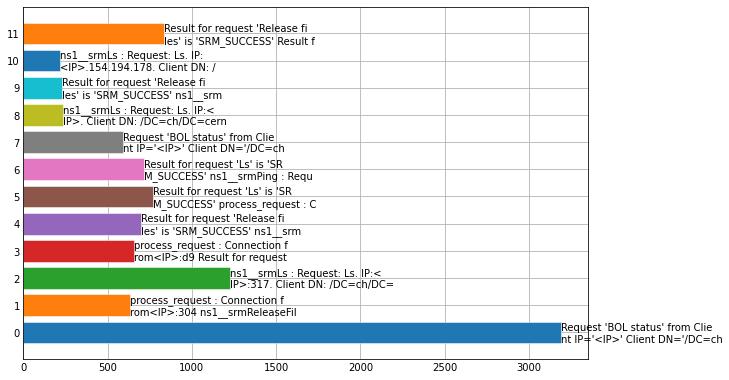

In [27]:
plt.style.use('_mpl-gallery')

# plot:
fig, ax = plt.subplots(figsize = (8, 5))

for l, c in zip(label, count):
    ax.barh(l, c, linewidth=0.5, edgecolor="white", label=logs.message[logs.kmean_labels==l][0])
    plt.text(c, l-0.35, logs.message[logs.kmean_labels==l][0][:30]+'\n'+logs.message[logs.kmean_labels==l][0][30:60])


# ax.set(xticks=np.arange(0, max(count), 10), yticks=label)
ax.set(yticks=label)

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 56), yticks=np.linspace(0, 56, 9))

# ax.legend()
plt.show()

In [28]:
import re

error = [0] * len(label)

for l in label:
    for msg in logs.message[logs.kmean_labels==l]:
        resultE = re.search('error', msg.lower())
        resultF = re.search('failure', msg.lower())
        resultP = re.search('problem', msg.lower())
        if resultE!=None :
            error[l] += 1
        if resultF!=None:
            error[l] += 1
        if resultP!=None:
            error[l] += 1
            
error

[0, 0, 0, 50, 0, 0, 452, 0, 40, 0, 145, 738]

<BarContainer object of 1 artists>

Text(3191, -0.35, "Request 'BOL status' from Clie\nnt IP='<IP>' Client DN='/DC=ch")

<BarContainer object of 1 artists>

Text(635, 0.65, 'process_request : Connection f\nrom<IP>:304 ns1__srmReleaseFil')

<BarContainer object of 1 artists>

Text(1228, 1.65, 'ns1__srmLs : Request: Ls. IP:<\nIP>:317. Client DN: /DC=ch/DC=')

<BarContainer object of 1 artists>

Text(658, 2.65, 'process_request : Connection f\nrom<IP>:d9 Result for request ')

<BarContainer object of 1 artists>

Text(700, 3.65, "Result for request 'Release fi\nles' is 'SRM_SUCCESS' ns1__srm")

<BarContainer object of 1 artists>

Text(771, 4.65, "Result for request 'Ls' is 'SR\nM_SUCCESS' process_request : C")

<BarContainer object of 1 artists>

Text(715, 5.65, "Result for request 'Ls' is 'SR\nM_SUCCESS' ns1__srmPing : Requ")

<BarContainer object of 1 artists>

Text(591, 6.65, "Request 'BOL status' from Clie\nnt IP='<IP>' Client DN='/DC=ch")

<BarContainer object of 1 artists>

Text(235, 7.65, 'ns1__srmLs : Request: Ls. IP:<\nIP>. Client DN: /DC=ch/DC=cern')

<BarContainer object of 1 artists>

Text(227, 8.65, "Result for request 'Release fi\nles' is 'SRM_SUCCESS' ns1__srm")

<BarContainer object of 1 artists>

Text(217, 9.65, 'ns1__srmLs : Request: Ls. IP: \n<IP>.154.194.178. Client DN: /')

<BarContainer object of 1 artists>

Text(832, 10.65, "Result for request 'Release fi\nles' is 'SRM_SUCCESS' Result f")

[[<matplotlib.axis.YTick at 0x1e4453c5600>,

<bound method _make_class_factory.<locals>.class_factory.<locals>.subcls.set of <AxesSubplot:>>

Text(0.5, 1.0, 'frontend-20200307-12centroids  [0, 0, 0, 50, 0, 0, 452, 0, 40, 0, 145, 738]')

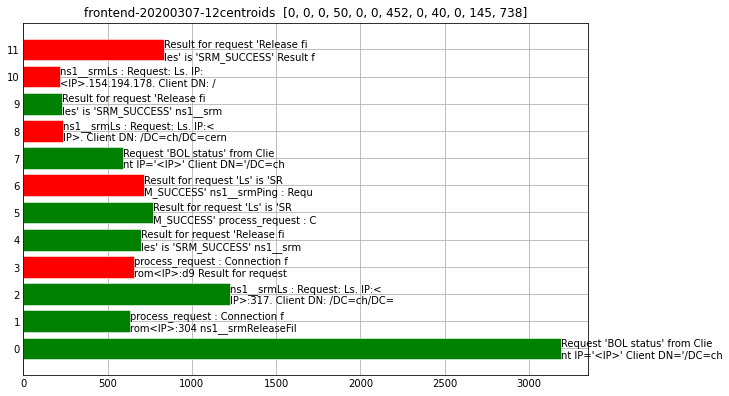

In [29]:
# plot:
fig, ax = plt.subplots(figsize = (8, 5))

for l, c in zip(label, count):
    if error[l] > 0:
        color='red'
    else:
        color='green'
    ax.barh(l, c, linewidth=0.5, color=color, edgecolor="white", label=logs.message[logs.kmean_labels==l][0])
    plt.text(c, l-0.35, logs.message[logs.kmean_labels==l][0][:30]+'\n'+logs.message[logs.kmean_labels==l][0][30:60])


# ax.set(xticks=np.arange(0, max(count), 10), yticks=label)
ax.set(yticks=label)
ax.set
# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 56), yticks=np.linspace(0, 56, 9))



# ax.legend()
plt.title(f'frontend-202003{v}-{n_clusters}centroids  '+str(error))
plt.savefig(f'frontend-202003{v}-{n_clusters}centroids', bbox_inches ="tight")
plt.show()

### Check the true label (if available)

Questa parte servirebbe se sapessi a priori a quale categoria appartiene ogni processo per controllare che l'algoritmo abbia prodotto i risultati attesi, ma non è questo il caso

## Conclusions and Next Steps
Summarize findings here